## Deduplicating the febrl3 dataset

See A.2  [here](https://arxiv.org/pdf/2008.04443.pdf) and [here](https://recordlinkage.readthedocs.io/en/latest/ref-datasets.html) for the source of this data

In [1]:
import pandas as pd 
import altair as alt
alt.renderers.enable('mimetype')

df = pd.read_csv("./data/febrl/dataset3.csv", delimiter=", ", dtype={"date_of_birth":str}, engine="python")
df["cluster"] = df["rec_id"].apply(lambda x: "-".join(x.split('-')[:2]))
df.head(2)

,rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,cluster
0,rec-1496-org,mitchell,green,7.0,wallaby place,delmar,cleveland,2119,sa,19560409,1804974,rec-1496
1,rec-552-dup-3,harley,mccarthy,177.0,pridhamstreet,milton,marsden,3165,nsw,19080419,6089216,rec-552


In [2]:
from splink.duckdb.duckdb_linker import DuckDBLinker

settings = {
    "unique_id_column_name": "rec_id",
    "link_type": "dedupe_only",
}

linker = DuckDBLinker(df, settings)

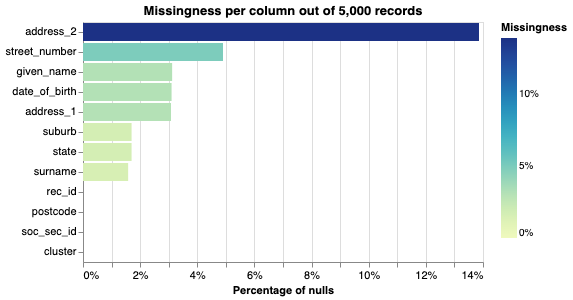

In [3]:
linker.missingness_chart()

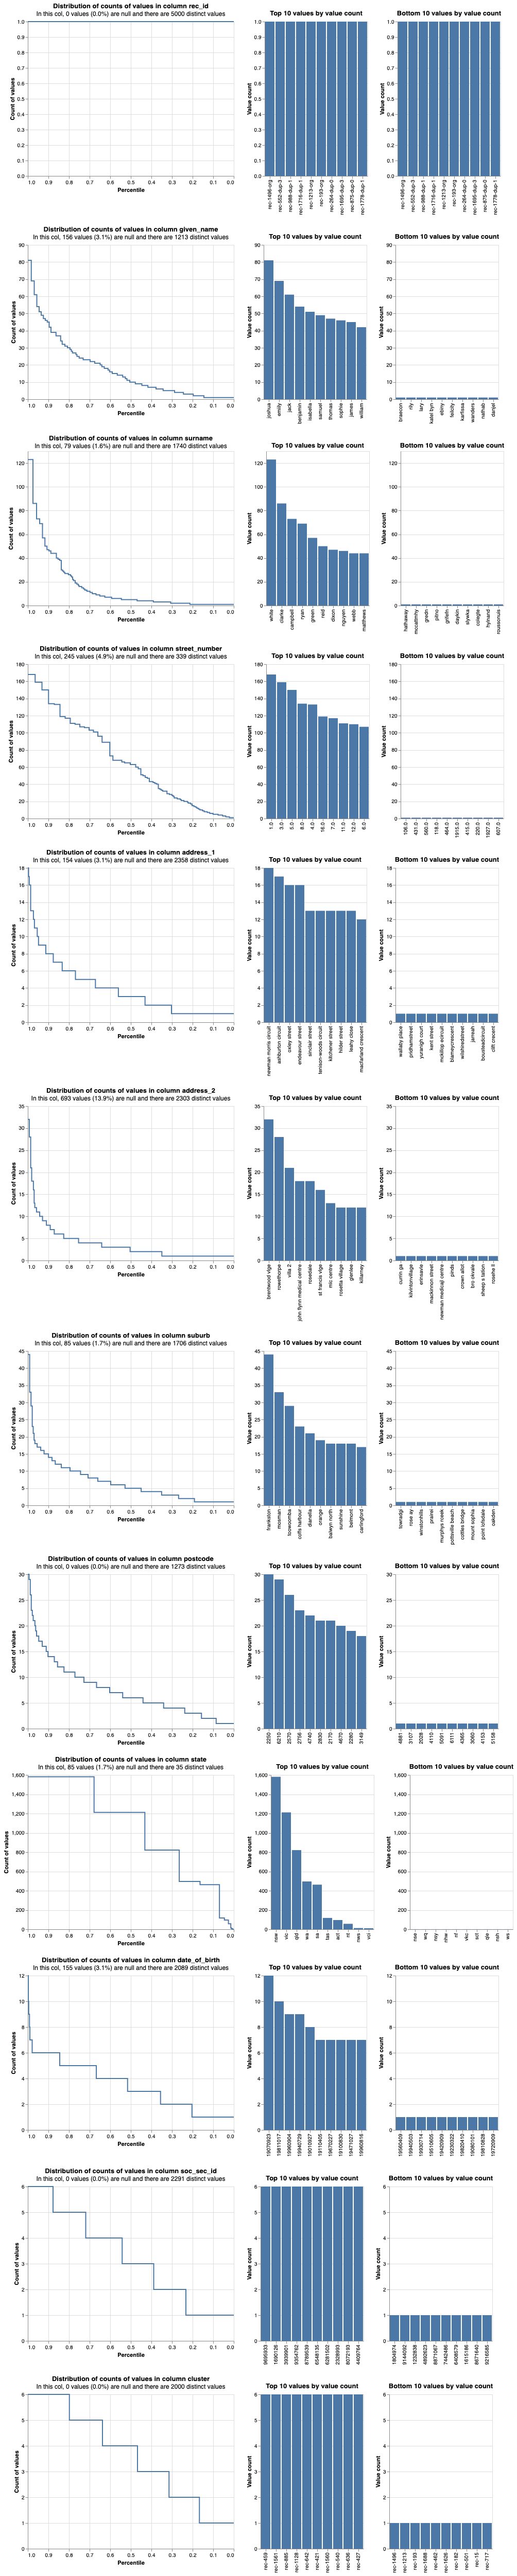

In [4]:
linker.profile_columns(list(df.columns))

In [5]:
linker = DuckDBLinker(df, settings)
deterministic_rules = [
    "l.soc_sec_id = r.soc_sec_id",
    "l.given_name = r.given_name and l.surname = r.surname and l.date_of_birth = r.date_of_birth",
    "l.given_name = r.surname and l.surname = r.given_name and l.date_of_birth = r.date_of_birth"
]

linker.estimate_probability_two_random_records_match(deterministic_rules, recall=0.9)

Probability two random records match is estimated to be  0.000527.
This means that amongst all possible pairwise record comparisons, one in 1,899.32 are expected to match.  With 12,497,500 total possible comparisons, we expect a total of around 6,580.00 matching pairs


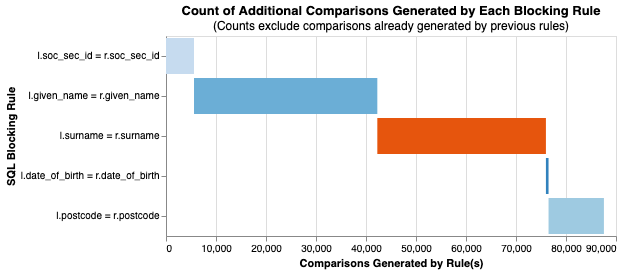

In [6]:
potential_blocking_rules = [
        "l.soc_sec_id = r.soc_sec_id",
        "l.given_name = r.given_name",
        "l.surname = r.surname",
        "l.date_of_birth = r.date_of_birth",
        "l.postcode = r.postcode"
]
linker.cumulative_num_comparisons_from_blocking_rules_chart(potential_blocking_rules)

In [7]:
from splink.duckdb.duckdb_linker import DuckDBLinker
import splink.duckdb.duckdb_comparison_level_library as cll
import splink.duckdb.duckdb_comparison_library as cl

settings = {
    "unique_id_column_name": "rec_id",
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": potential_blocking_rules,
    "comparisons": [
        {
            "output_column_name": "Given name",
            "comparison_levels": [
                cll.null_level("given_name"),
                cll.exact_match_level("given_name", term_frequency_adjustments=True),
                cll.columns_reversed_level("given_name", "surname"),
                cll.distance_function_level("given_name", "jaro_winkler_similarity", 0.9),
                cll.distance_function_level("given_name", "jaro_winkler_similarity", 0.7),
                cll.else_level(),
            ],
        },
        {
            "output_column_name": "Surname",
            "comparison_levels": [
                cll.null_level("surname"),
                cll.exact_match_level("surname",  term_frequency_adjustments=True),
                cll.distance_function_level("surname", "jaro_winkler_similarity", 0.9),
                cll.distance_function_level("surname", "jaro_winkler_similarity", 0.7),
                cll.else_level(),
            ],
        },
        cl.levenshtein_at_thresholds(
            "date_of_birth", [1, 2], term_frequency_adjustments=True
        ),
        cl.levenshtein_at_thresholds("soc_sec_id", [2]),
        cl.exact_match("street_number", term_frequency_adjustments=True),
        cl.exact_match("postcode", term_frequency_adjustments=True),
    ],
    "retain_intermediate_calculation_columns": True,
}

linker = DuckDBLinker(df, settings)

In [8]:
cll.columns_reversed_level("given_name", "surname").as_dict()

{'sql_condition': '"given_name_l" = "surname_r" and "given_name_r" = "surname_l"',
 'label_for_charts': 'Exact match on reversed cols'}

In [9]:
linker.estimate_u_using_random_sampling(target_rows=1e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - Given name (no m values are trained).
    - Surname (no m values are trained).
    - date_of_birth (no m values are trained).
    - soc_sec_id (no m values are trained).
    - street_number (no m values are trained).
    - postcode (no m values are trained).


In [10]:
comparison = linker._settings_obj.comparisons[2].as_dict()

In [11]:
comp_rev_dob = linker._settings_obj.comparisons[2]
cl_rev_dob = linker._settings_obj.comparisons[2].comparison_levels[1]

comp_rev_postcode = linker._settings_obj.comparisons[5]
cl_rev_postcode = linker._settings_obj.comparisons[5].comparison_levels[1]

session_dob = linker.estimate_parameters_using_expectation_maximisation("substr(l.date_of_birth,1,3) = substr(r.date_of_birth,1,3)", comparison_levels_to_reverse_blocking_rule=[cl_rev_dob],  comparisons_to_deactivate=[comp_rev_dob])
session_postcode = linker.estimate_parameters_using_expectation_maximisation("substr(l.postcode,1,2) = substr(r.postcode,1,2)", comparison_levels_to_reverse_blocking_rule=[cl_rev_postcode],  comparisons_to_deactivate=[comp_rev_postcode])


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
substr(l.date_of_birth,1,3) = substr(r.date_of_birth,1,3)

Parameter estimates will be made for the following comparison(s):
    - Given name
    - Surname
    - soc_sec_id
    - street_number
    - postcode

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - date_of_birth

Iteration 1: Largest change in params was -0.363 in the m_probability of Surname, level `Exact match`
Iteration 2: Largest change in params was 0.0107 in the m_probability of Given name, level `All other comparisons`
Iteration 3: Largest change in params was 0.000649 in the m_probability of Surname, level `All other comparisons`
Iteration 4: Largest change in params was 9.64e-05 in the m_probability of soc_sec_id, level `All other comparisons`

EM converged after 4 iterations

Your model is not yet fully trained. Missing estimates for:
    - date_of_

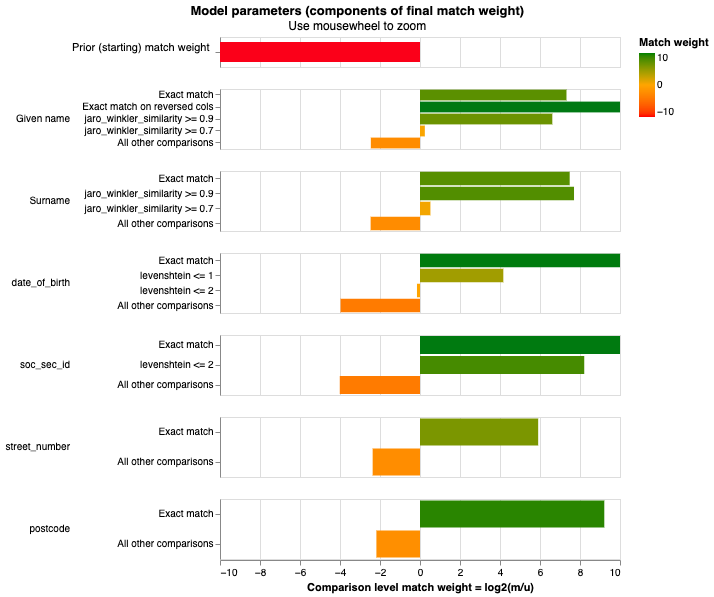

In [12]:
linker.match_weights_chart()

In [13]:
results = linker.predict(threshold_match_probability=0.2)

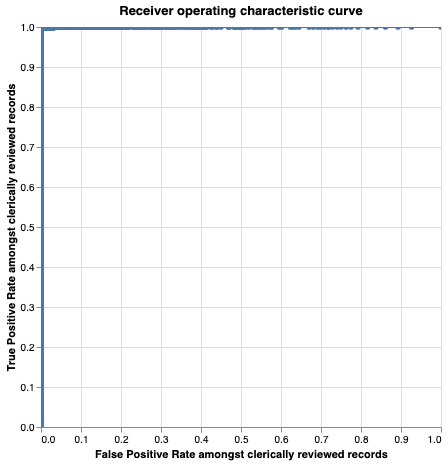

In [14]:
linker.roc_chart_from_labels_column("cluster")

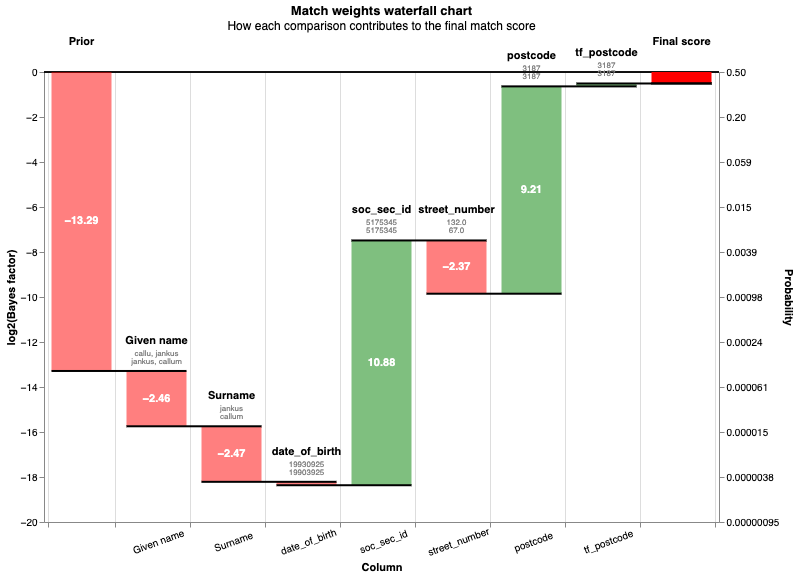

In [15]:
records = linker.prediction_errors_from_labels_column("cluster").as_record_dict(limit=5)
linker.waterfall_chart(records)

In [16]:
linker.prediction_errors_from_labels_column("cluster").as_pandas_dataframe(limit=5)

,clerical_match_score,found_by_blocking_rules,match_weight,match_probability,rec_id_l,rec_id_r,given_name_l,given_name_r,surname_l,surname_r,...,postcode_l,postcode_r,gamma_postcode,tf_postcode_l,tf_postcode_r,bf_postcode,bf_tf_adj_postcode,cluster_l,cluster_r,match_key
0,1.0,True,-0.510180,0.412502,rec-785-dup-1,rec-785-dup-4,callu,jankus,jankus,callum,...,3187,3187,1,0.0012,0.0012,594.214775,1.093316,rec-785,rec-785,0
1,1.0,True,-2.363624,0.162691,rec-260-dup-0,rec-260-dup-2,robin,morrison,morrison,rob inq,...,6169,6196,0,0.0026,0.0002,0.220692,1.000000,rec-260,rec-260,0
2,1.0,True,-3.007989,0.110565,rec-90-dup-0,rec-90-dup-1,dylan,dylan,campbell,nguyen,...,2604,2640,0,0.0004,0.0024,0.220692,1.000000,rec-90,rec-90,0
3,1.0,True,-6.175623,0.013645,rec-1460-dup-0,rec-1460-dup-2,benjamin,noah,weller,weller,...,7305,7307,0,0.0014,0.0002,0.220692,1.000000,rec-1460,rec-1460,0
4,1.0,True,-8.360237,0.003034,rec-1727-dup-0,rec-1727-dup-1,josha,campblel,campbell,joshua,...,3198,3189,0,0.0008,0.0008,0.220692,1.000000,rec-1727,rec-1727,0
